In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

In [2]:
from rltorch.agents.core import BaseAgent
from rltorch.memories import SequentialMemory
from rltorch.processors import AtariProcessor
from rltorch.layers import Flatten


class DQNAgent(BaseAgent):
    def __init__(self, state_shape, action_config, processor=None,
                 reward_reshape=None, batch_size=64, lr=1e-2,
                 network_config=None, memory_length=1e6,
                 window_length=4, ignore_episode_boundaries=False,
                 target_update_freq=1e4,
                 gamma=.99, eps_max=1.0, eps_min=0.1, decay_frame=1e6):
        super(DQNAgent, self).__init__(state_shape, action_config, processor, reward_reshape)
        self.network_config = network_config
        self.memory = SequentialMemory(limit=int(memory_length),
                                       window_length=int(window_length),
                                       ignore_episode_boundaries=ignore_episode_boundaries)
        self.processor = processor
        self.batch_size = batch_size
        self.q_network = self.build_network()
        self.target_q_network = self.build_network()
        self._update_target()
        # Build optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        # Parameters for epsilon greedy
        self.step = 0
        self.eps_min = eps_min
        self.eps_max = eps_max
        self.decay_frame = decay_frame
        self.gamma = gamma
        self.target_update_freq = int(target_update_freq)
        
    def forward(self, x):
        x = self.q_network(x)
        return x
        
    def predict(self, observation):
        if np.random.random() < self.epsilon:
            n_action = self.action_config['n_action']
            action = np.random.randint(0, n_action)
        else:
            action = self._max_predict(observation)
        return action
            
    def _max_predict(self, observation):
        if self.processor is not None:
            observation = self.processor.process(observation)
        state = self.memory.get_recent_state(observation)
        state = torch.tensor(state).float().unsqueeze(0)
        scores = self.forward(state)
        return torch.max(scores, -1)[1][0]
    
    def observe(self, observation, action, reward, termianl, info, training=True):
        if self.processor is not None:
            observation = self.processor.process(observation)
        # action => (observation, reward, termianl, info) 
        self.memory.append(observation, action, reward, termianl, training)
    
    def build_network(self):
        model = nn.Sequential()
        in_features = self.state_shape[0]
        model.add_module('conv1', nn.Conv2d(in_features, 32, 8, stride=4))
        model.add_module('relu1', nn.ReLU())
        model.add_module('conv2', nn.Conv2d(32, 64, 4, stride=2))
        model.add_module('relu2', nn.ReLU())
        model.add_module('conv3', nn.Conv2d(64, 64, 3, stride=1))
        model.add_module('relu3', nn.ReLU())
        model.add_module('flatten', Flatten())
        # Calculate dimention after passing test data
        dim = self._calc_dim(model)
        # Fully connected layers
        model.add_module('fc1', nn.Linear(dim, 512))
        model.add_module('relu4', nn.ReLU())
        model.add_module('fc2', nn.Linear(512, self.action_config['n_action']))
        return model
        
    def _calc_dim(self, model):
        x = torch.randn([1] + list(self.state_shape))
        x = model(x)
        return x.size(-1)
    
    @property
    def epsilon(self):
        decayed_eps = self.eps_min + self.step * (self.eps_max - self.eps_min) / self.decay_frame
        return max(self.eps_min, decayed_eps)
    
    
    def fit(self, *args, **kwargs):
        if self.memory.nb_entries < self.batch_size:
            return
        experiences = self.memory.sample()
        actions = experiences.action
        rewards = experiences.reward
        terminals = experiences.terminal
        values = experiences.value
        log_
        

        # Compute state action values
        q_output = self.q_network(batch_state0)
        state_action_values = q_output.gather(1, batch_action.unsqueeze(1))[:, 0]

        # Compute target values
        next_state_values = self.target_q_network(batch_state1).max(1)[0].detach()
        next_state_values[batch_terminal1] = torch.zeros(self.batch_size)[batch_terminal1]
        target_values = batch_reward + self.gamma * next_state_values

        # Compute Huber loss
        loss = F.smooth_l1_loss(state_action_values, target_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.q_network.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        self.step += 1
        # Clear memory
        self.memory.reset()
        
        
    def _update_target(self):
        self.target_q_network.load_state_dict(self.q_network.state_dict())

In [3]:
import gym

env = gym.make('Breakout-v0').unwrapped

/home/tom/work/library/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [7]:
from tqdm import tqdm_notebook


class Runner(object):
    def __init__(self, env, agent, n_workers=1):
        self.agent = agent
        self.env0 = env
        # Parallelize environment
        if n_workers > 1:
            env = [deepcopy(env) for _ in range(n_workers)]
            self.env = ParallelEnv(env)
        else:
            self.env = env
        
    def simulate(self, n_frames=1e6, training=True, render_freq=1, notebook=False):
        if training:
            env = self.env
        else:
            env = self.env0
        n_frames = int(n_frames)
        reward_list = []
        if notebook:
            iteration = tqdm_notebook(range(n_frames))
        else:
            iteration = tqdm(range(n_frames))
        obs = env.reset()
        for step in iteration:
            action = self.agent.predict(obs)
            new_obs, reward, terminal, info = self.env.step(action)
            self.agent.observe(obs, action, reward, terminal, info, training=training)
            self.agent.fit()
            obs = new_obs
            if render_freq > 0 and step % render_freq == 0:
                env.render()
        return self.agent

In [8]:
from rltorch.agents import RandomAgent

FRAME_WIDTH = 84
FRAME_HEIGHT = 84
WINDOW_LENGTH = 3
# state_shape = env.observation_space.shape
state_shape = (WINDOW_LENGTH, FRAME_WIDTH, FRAME_HEIGHT)
action_config = {'n_action': env.action_space.n, 'type': 'integer'}
processor = AtariProcessor(FRAME_WIDTH, FRAME_HEIGHT)
agent = DQNAgent(state_shape, action_config, processor=processor,
                 window_length=WINDOW_LENGTH)
# agent = RandomAgent(state_shape, action_config)

runner = Runner(env, agent)

reward_list = runner.simulate(training=True, notebook=True)

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

/home/tom/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/tom/anaconda3/lib/python3.6/site-packages/rltorch-0.1-py3.6.egg/rltorch/memories.py:35: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!


KeyboardInterrupt: 

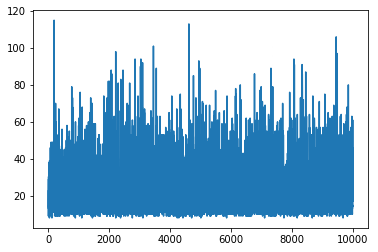

In [51]:
import matplotlib.pyplot  as plt
%matplotlib inline

plt.plot(reward_list)

In [8]:
samples = agent.memory.sample(32)

In [15]:
samples[0].state1


[array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8),
 array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8),
 array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)]

In [7]:
x = torch.randn(3, 4)

In [8]:
model = nn.Sequential()

In [9]:
model.add_module('linear', nn.Linear(4, 6))
model.add_module('linear2', nn.Linear(6, 10))
model(x).shape

torch.Size([3, 10])

In [10]:
help(model.add_module)

Help on method add_module in module torch.nn.modules.module:

add_module(name, module) method of torch.nn.modules.container.Sequential instance
    Adds a child module to the current module.
    
    The module can be accessed as an attribute using the given name.
    
    Args:
        name (string): name of the child module. The child module can be
            accessed from this module using the given name
        parameter (Module): child module to be added to the module.



In [13]:
x.shape

torch.Size([3, 4])

In [34]:
action = torch.randint(0, 3, (3,)).long()

In [35]:
action

tensor([ 1,  2,  0])

In [36]:
x.gather(1, action)

RuntimeError: invalid argument 4: Index tensor must have same dimensions as input tensor at /pytorch/aten/src/TH/generic/THTensorMath.c:581

In [37]:
x[:, action]

tensor([[-0.4560,  0.1501, -2.2260],
        [-0.7603, -0.7518, -0.0867],
        [-0.6491, -1.6571,  0.7313]])

In [46]:
x.gather(1, action.unsqueeze(1))[:, 0]

tensor([-0.4560, -0.7518,  0.7313])

In [42]:
x.shape

torch.Size([3, 4])

In [44]:
action.shape

torch.Size([3])

In [45]:
action.unsqueeze(1).shape

torch.Size([3, 1])